In [ ]:
import torch
import itertools
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
from torchvision import transforms
import torchvision.transforms.functional as F
import random
from tqdm import tqdm
from scipy.ndimage import rotate
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pandas as pd
from collections import OrderedDict

In [ ]:
def window_nd(a, window, steps = None):
    ashp = a.shape
    pad = np.zeros((len(window),2))
    for _ in range(pad.shape[0]):
        pad[_,1] = window[_] - (steps[_] * (window[_] // steps[_]) + ashp[_] % steps[_])
        while pad[_,1] < 0:
            pad[_,1] += steps[_]
    pad = pad.astype(int)
    a = np.pad(a, pad)
    ashp = np.array(a.shape)
    wshp = np.array(window).reshape(-1)
    if steps:
        stp = np.array(steps).reshape(-1)
    else:
        stp = np.ones_like(ashp)
    astr = np.array(a.strides)
    assert np.all(np.r_[ashp.size == wshp.size, wshp.size == stp.size, wshp <= ashp])
    shape = tuple((ashp - wshp) // stp + 1) + tuple(wshp)
    strides = tuple(astr * stp) + tuple(astr)
    as_strided = np.lib.stride_tricks.as_strided
    aview = as_strided(a, shape = shape, strides = strides)
    return aview

In [ ]:
train_phenotype = os.listdir('/scratch/liy31/myjupyter/capstone/phenotype_labels/')

In [ ]:
train_data = os.listdir('/scratch/liy31/myjupyter/capstone/phenotype_labels/')
selected_data1 = set(['_'.join(_.split('_')[:4]) for _ in train_data])
np.unique([_[:13] for _ in selected_data1], return_counts=True)

(array(['121919_Myo089', '121919_Myo208', '121919_Myo231', '121919_Myo253',
        '121919_Myo368', '121919_Myo388', '121919_Myo511'], dtype='<U13'),
 array([36, 35,  8, 33, 52, 23,  9]))

In [ ]:
train_data = os.listdir('/scratch/liy31/myjupyter/capstone/train_label/')
selected_data2 = set(['_'.join(_.split('_')[:4]) for _ in train_data])
np.unique([_[:13] for _ in selected_data2], return_counts=True)

(array(['121919_Myo089', '121919_Myo208', '121919_Myo231', '121919_Myo253',
        '121919_Myo368', '121919_Myo388', '121919_Myo511'], dtype='<U13'),
 array([36, 27,  8, 33, 52, 23,  9]))

In [ ]:
selected_data = selected_data1.intersection(selected_data2)
np.unique([_[:13] for _ in selected_data2], return_counts=True)

(array(['121919_Myo089', '121919_Myo208', '121919_Myo231', '121919_Myo253',
        '121919_Myo368', '121919_Myo388', '121919_Myo511'], dtype='<U13'),
 array([36, 27,  8, 33, 52, 23,  9]))

In [ ]:
train_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy', _ + '_mask_' + str(idx) + '.npy', _+ '_class_' + str(idx) + '.npy') for idx in range(48)] 
              for _ in selected_data if _[:13] in ['121919_Myo089', '121919_Myo253', '121919_Myo368']]
validation_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy', _ + '_mask_' + str(idx) + '.npy', _+ '_class_' + str(idx) + '.npy') for idx in range(48)] 
                   for _ in selected_data if _[:13] in ['121919_Myo208', '121919_Myo388']]
test_list = [[(_ + '_data_' + str(idx) + '.npy', _ + '_target_' + str(idx) + '.npy', _ + '_mask_' + str(idx) + '.npy', _+ '_class_' + str(idx) + '.npy') for idx in range(48)] 
             for _ in selected_data if _[:13] in ['121919_Myo231', '121919_Myo511']]
train_list = list(itertools.chain(*train_list))
validation_list = list(itertools.chain(*validation_list))
test_list = list(itertools.chain(*test_list))
print('train data: {}'.format(len(train_list)))
print('validation data: {}'.format(len(validation_list)))
print('test data: {}'.format(len(test_list)))

train data: 5808
validation data: 2352
test data: 816


In [ ]:
def classify_TFH_B(df):
    if df['cd19'] == 0 and  df['cd4'] == 1 and  df['cd27'] == 1 :
        val = 'TFH'
    elif df['cd19'] == 1 and  df['cd4'] == 0 and  df['cd27'] == 0 :
        val = 'B'
    else:
        val = 'others'
    return val

In [ ]:
def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)

In [ ]:
path_to_data = '/scratch/liy31/myjupyter/capstone/CD27/' + '121919_Myo089_[7110,44031]_component'+ '_data.tif'
img = read_tiff(path_to_data)


/home/liy31/.local/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: [Errno 22] Invalid argument
  warnings.warn(str(msg))
<ipython-input-9-58dd332c2e31>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(images)


In [ ]:
path_to_target = '/scratch/liy31/myjupyter/capstone/CD27_labels/' + '121919_Myo089_[7110,44031]_component' + '_datalabels'
label = pd.read_table(path_to_target, usecols=[1,2,3])
    
pheno = pd.read_table('/scratch/liy31/myjupyter/capstone/phenotype_labels/'+ '121919_Myo089_[7110,44031]_component' +'_dataMeasured')
pheno['type'] = pheno.apply(classify_TFH_B, axis=1)
pheno['type'] = pheno.type.astype('category')
pheno['Label'] = pheno['listname']

result = pd.merge(label, pheno[['Label','type']], how='right', on=['Label'])
type_dic = {"type": {"B": 1, "TFH": 2,"others": 3}}
result.replace(type_dic, inplace=True)





In [ ]:
result

,Label,X,Y,type
0,Cell1,1393.06,631.71,1
1,Cell1,1392.97,633.04,1
2,Cell1,1392.71,634.37,1
3,Cell1,1392.11,635.61,1
4,Cell1,1391.30,636.73,1
...,...,...,...,...
29595,Cell925,1439.16,822.01,3
29596,Cell925,1439.99,822.53,3
29597,Cell925,1440.56,823.33,3
29598,Cell925,1441.19,824.11,3


In [ ]:
result.groupby(['type']).size()

type
1      768
2     1280
3    27552
dtype: int64

In [ ]:
target = np.zeros((3,)+img[0].shape)
for x, y, z in zip(result.X, result.Y, result.type):
    try:
        target[z-1, int(y)-1, int(x)-1] = 1
    except:
        continue

In [ ]:
target.shape

(3, 1408, 1876)

In [ ]:
target[0].sum()

748.0

In [ ]:
target[1].sum()

1236.0

In [ ]:
target[2].sum()

26460.0

In [ ]:
array_list = []
for idx in range(3):
    aview = window_nd(target[idx], (256, 256), (256,256)).reshape(-1,256,256)
    array_list.append(aview)
aview = np.stack(np.array(array_list)).transpose((1,0,2,3))

In [ ]:
aview = window_nd(target, (256, 256), (256,256))
    aview = aview.reshape(-1, 256, 256)
    for idx in range(aview.shape[0]):
        np.save('./Colton AI project/Myositis Images/train_label/' + _ + '_target_' + str(idx), aview[idx])
        

In [ ]:
aview.shape

(48, 3, 256, 256)

In [ ]:
aview[0].shape

(3, 256, 256)

In [ ]:
for _ in tqdm(selected_data):
    path_to_data = '/scratch/liy31/myjupyter/capstone/CD27/' + _ +'_data.tif'
    img = read_tiff(path_to_data)
   
    path_to_target = '/scratch/liy31/myjupyter/capstone/CD27_labels/' + _ + '_datalabels'
    label = pd.read_table(path_to_target, usecols=[1,2,3])
    
    pheno = pd.read_table('/scratch/liy31/myjupyter/capstone/phenotype_labels/'+ _ +'_dataMeasured')
    pheno['type'] = pheno.apply(classify_TFH_B, axis=1)
    pheno['type'] = pheno.type.astype('category')
    pheno['Label'] = pheno['listname']

    result = pd.merge(label, pheno[['Label','type']], how='right', on=['Label'])
    type_dic = {"type": {"B": 1, "TFH": 2,"others": 3}}
    result.replace(type_dic, inplace=True)

    target = np.zeros((3,)+img[0].shape)
    for x, y, z in zip(result.X, result.Y, result.type):
        try:
            target[z-1, int(y)-1, int(x)-1] = 1
        except:
            continue
    
    array_list = []
    for idx in range(3):
        aview = window_nd(target[idx], (256, 256), (256,256)).reshape(-1,256,256)
        array_list.append(aview)
    aview = np.stack(np.array(array_list)).transpose((1,0,2,3))
    
    for idx in range(aview.shape[0]):
        np.save('/scratch/liy31/myjupyter/capstone/train_pheno_3channel/' + _ + '_class_' + str(idx), aview[idx])   

    

  0%|          | 0/187 [00:00<?, ?it/s]<ipython-input-9-58dd332c2e31>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(images)
100%|██████████| 187/187 [10:35<00:00,  3.40s/it]


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None, rotation=None):
        self.file_list = file_list
        self.transform = transform
        self.rotation = rotation

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):

        inputs = np.load('/scratch/liy31/myjupyter/capstone/train_data_class_nolap/' + self.file_list[idx][0])
        bdry = np.load('/scratch/liy31/myjupyter/capstone/train_label/'  + self.file_list[idx][1])
        mask_label = np.load('/scratch/liy31/myjupyter/capstone/train_mask/' + self.file_list[idx][2])
        pheno_label = np.load('/scratch/liy31/myjupyter/capstone/train_pheno_3channel/' + self.file_list[idx][3])
        
        bdry = torch.from_numpy(bdry).unsqueeze(0)
        mask_label = torch.from_numpy(mask_label / 255).unsqueeze(0)
        label = torch.max(bdry * 2, mask_label).long().squeeze()
        
        pheno_label = torch.from_numpy(pheno_label).unsqueeze(0).float()
        
        inputs = torch.from_numpy(inputs).float()
        
        return (inputs, label, bdry, mask_label,pheno_label)

In [ ]:
dataloader = {}
dataloader['train'] = DataLoader(CustomDataset(train_list,transform = None, rotation=None), batch_size=16, shuffle=True, num_workers=0, drop_last=False)
dataloader['validation'] = DataLoader(CustomDataset(validation_list), batch_size=16, shuffle=False, num_workers=0, drop_last=False)
dataloader['test'] = DataLoader(CustomDataset(test_list), batch_size=16, shuffle=False, num_workers=0, drop_last=False)
datasize = {'train': len(train_list), 'validation': len(validation_list), 'test': len(test_list)}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
inputs, labels, bdry, mask_label, pheno_label = next(iter(dataloader['train']))


In [ ]:
inputs[0].size()

torch.Size([4, 256, 256])

In [ ]:
inputs[0][0:3,:,:].size()

torch.Size([3, 256, 256])

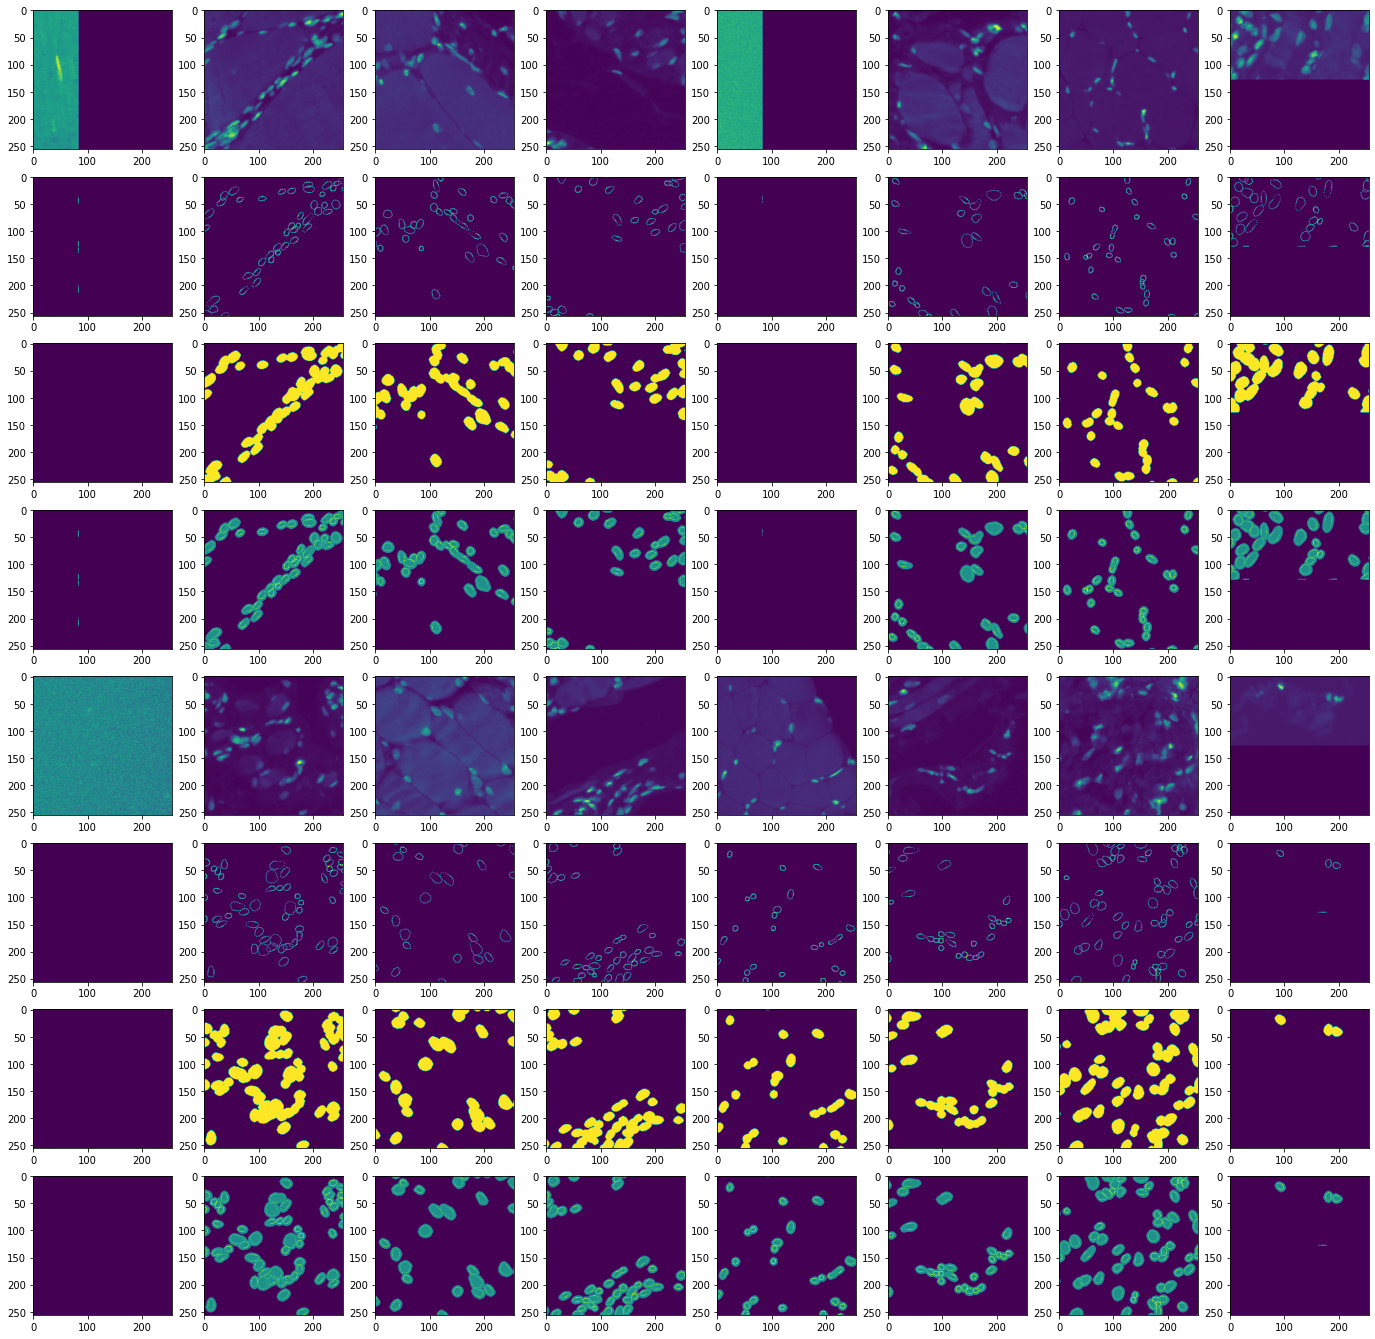

In [ ]:
plt.figure(figsize=(24,24))
for _ in range(8):
    plt.subplot(8,8,_+1)
    plt.imshow(inputs[_].squeeze()[0,:,:].numpy())
    plt.subplot(8,8,_+9)
    plt.imshow(bdry[_].squeeze().numpy())
    plt.subplot(8,8,_+17)
    plt.imshow(mask_label[_].squeeze().numpy())
    plt.subplot(8,8,_+25)
    plt.imshow(labels[_].squeeze().numpy())
for _ in range(8,16):
    plt.subplot(8,8,_+25)
    plt.imshow(inputs[_].squeeze()[0,:,:].numpy())
    plt.subplot(8,8,_+33)
    plt.imshow(bdry[_].squeeze().numpy())
    plt.subplot(8,8,_+41)
    plt.imshow(mask_label[_].squeeze().numpy())
    plt.subplot(8,8,_+49)
    plt.imshow(labels[_].squeeze().numpy())
plt.show()

In [ ]:
train_data = os.listdir('/scratch/liy31/myjupyter/capstone/train_data_class/')
train_label = os.listdir('/scratch/liy31/myjupyter/capstone/train_label/')
train_mask_label = os.listdir('/scratch/liy31/myjupyter/capstone/train_mask/')
train_pheno_label = os.listdir('/scratch/liy31/myjupyter/capstone/train_pheno/')

In [ ]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [ ]:
sigmoid = nn.Sigmoid()

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, maximum_patient=5):
    since = time.time()
    
    init_model_wts = copy.deepcopy(model.state_dict())
    best_pre_model_wts = copy.deepcopy(model.state_dict())
    best_rec_model_wts = copy.deepcopy(model.state_dict())
    best_f1_model_wts = copy.deepcopy(model.state_dict())
    best_pre = 0.0
    best_rec = 0.0
    best_f1 = 0.0
    best_loss = 1e10
    patient_cnt = 0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_both_corrects = torch.zeros(3).to(device)
            running_true_corrects = torch.zeros(3).to(device)
            running_pred_corrects = torch.zeros(3).to(device)

            # Iterate over data.
            for inputs, label, bdry, mask_label,target in dataloader[phase]:
                inputs = inputs.to(device)
                target = target.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print("output size:{}",outputs.size())
                    #print("target size:{}",target.size())
                    outputs = outputs.permute((0,2,3,1)).reshape((-1,3))
                    target = target.squeeze().permute((0,2,3,1)).reshape((-1,3))
                    #print("target size:{}",target.size())
                    #outputs = outputs.permute((0,2,3,1)).reshape((-1,3))
                    #target = target.permute((0,2,3,1)).reshape((-1,3))
                    loss = criterion(outputs, target)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                
                running_true_corrects += torch.sum(target.int(), axis=[0])
                running_pred_corrects += torch.sum(sigmoid(outputs)>0.5, axis=[0])
                running_both_corrects += torch.sum(target.int() & (sigmoid(outputs)>0.5), axis=[0])
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / datasize[phase]
            epoch_prec = running_both_corrects / running_pred_corrects
            epoch_rec = running_both_corrects / running_true_corrects
            epoch_f1 = 2*epoch_prec*epoch_rec / (epoch_prec+epoch_rec)

            print('{} Loss: {:.4f} precision Acc: {:.4f} recall Acc: {:.4f} f1 Acc: {:.4f}'.format(
                phase, epoch_loss, torch.mean(epoch_prec), torch.mean(epoch_rec), torch.mean(epoch_f1)))

            # deep copy the model
            if phase == 'validation':
                if torch.mean(epoch_f1) > best_f1:
                    best_f1 = torch.mean(epoch_f1)
                    best_f1_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({'model': model, 'optimizer': optimizer, 'scheduler': scheduler.state_dict(), 'loss': criterion.state_dict(), 
                                'epoch': epoch, 'initial_state': init_model_wts, 'precision': epoch_prec, 'recall': epoch_rec, 'f1': epoch_f1}, 
                               '/scratch/liy31/myjupyter/capstone/model_class/unet_f1_{:.3f}.pt'.format(torch.mean(epoch_f1).item()))
                    patient_cnt = 0
                else:
                    patient_cnt += 1

                if patient_cnt > maximum_patient:
                    break
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best f1 Acc: {:4f}'.format(best_f1))

In [ ]:
sigmoid = nn.Sigmoid()

def train_model(model, criterion1, criterion2, optimizer, scheduler, num_epochs=25, maximum_patient=5):
    since = time.time()
    
    init_model_wts = copy.deepcopy(model.state_dict())
    best_pre_model_wts = copy.deepcopy(model.state_dict())
    best_rec_model_wts = copy.deepcopy(model.state_dict())
    best_f1_model_wts = copy.deepcopy(model.state_dict())
    best_pre = 0.0
    best_rec = 0.0
    best_f1 = 0.0
    best_loss = 1e10
    patient_cnt = 0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_both_corrects = torch.zeros(3).to(device)
            running_true_corrects = torch.zeros(3).to(device)
            running_pred_corrects = torch.zeros(3).to(device)

            # Iterate over data.
            for inputs, label, bdry, mask_label,target in dataloader[phase]:
                inputs = inputs.to(device)
                target = target.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print("output size:{}",outputs.size())
                    #print("target size:{}",target.size())
                    outputs = outputs.permute((0,2,3,1)).reshape((-1,3))
                    target = target.squeeze().permute((0,2,3,1)).reshape((-1,3))
                    #print("target size:{}",target.size())
                    #outputs = outputs.permute((0,2,3,1)).reshape((-1,3))
                    #target = target.permute((0,2,3,1)).reshape((-1,3))
                    loss1 = criterion1(outputs, target)
                    loss2 = criterion2(outputs, target)
                    loss = 4*loss1 + loss2

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                
                running_true_corrects += torch.sum(target.int(), axis=[0])
                running_pred_corrects += torch.sum(sigmoid(outputs)>0.5, axis=[0])
                running_both_corrects += torch.sum(target.int() & (sigmoid(outputs)>0.5), axis=[0])
            if phase == 'train':
                scheduler.step()
            print("true corrects{}:",running_true_corrects)
            print("pred corrects{}:",running_pred_corrects)
            print("both corrects{}:",running_both_corrects)
            epoch_loss = running_loss / datasize[phase]
            epoch_prec = running_both_corrects / running_pred_corrects
            epoch_rec = running_both_corrects / running_true_corrects
            epoch_f1 = 2*epoch_prec*epoch_rec / (epoch_prec+epoch_rec)

            print('{} Loss: {:.4f} precision Acc: {:.4f} recall Acc: {:.4f} f1 Acc: {:.4f}'.format(
                phase, epoch_loss, torch.mean(epoch_prec), torch.mean(epoch_rec), torch.mean(epoch_f1)))

            # deep copy the model
            if phase == 'validation':
                if torch.mean(epoch_f1) > best_f1:
                    best_f1 = torch.mean(epoch_f1)
                    best_f1_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({'model': model, 'optimizer': optimizer, 'scheduler': scheduler.state_dict(), 'loss': criterion.state_dict(), 
                                'epoch': epoch, 'initial_state': init_model_wts, 'precision': epoch_prec, 'recall': epoch_rec, 'f1': epoch_f1}, 
                               '/scratch/liy31/myjupyter/capstone/model_class/unet_f1_{:.3f}.pt'.format(torch.mean(epoch_f1).item()))
                    patient_cnt = 0
                else:
                    patient_cnt += 1

                if patient_cnt > maximum_patient:
                    break
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best f1 Acc: {:4f}'.format(best_f1))

In [ ]:
sigmoid = nn.Sigmoid()

def train_mask(model, criterion1, criterion2,optimizer, scheduler, num_epochs=25, maximum_patient=5):
    since = time.time()
    
    init_model_wts = copy.deepcopy(model.state_dict())
    best_pre_model_wts = copy.deepcopy(model.state_dict())
    best_rec_model_wts = copy.deepcopy(model.state_dict())
    best_f1_model_wts = copy.deepcopy(model.state_dict())
    best_pre = 0.0
    best_rec = 0.0
    best_f1 = 0.0
    best_loss = 1e10
    patient_cnt = 0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_both_corrects = torch.zeros(3).to(device)
            running_true_corrects = torch.zeros(3).to(device)
            running_pred_corrects = torch.zeros(3).to(device)
            
            

            # Iterate over data.
            for inputs, label, bdry, mask_label,target in dataloader[phase]:
                inputs = inputs.to(device)
                label = label.to(device)
                target = target.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    outputs1 = outputs[:,3,:,:].reshape((-1,1))
                    label = label.reshape((-1,1))
                    label = label.type_as(outputs1)
                     
                    outputs2 = outputs[:,0:3,:,:].permute((0,2,3,1)).reshape((-1,3))
                    target = target.squeeze().permute((0,2,3,1)).reshape((-1,3))
                    
                    loss1 = criterion1(outputs1, label)
                    #print("loss1 ok")
                    loss2 = criterion2(outputs2, target)
                    #print("loss2 ok")
                    loss = 5*loss1+loss2

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                
                running_true_corrects += torch.sum(target.int(), axis=[0])
                running_pred_corrects += torch.sum(sigmoid(outputs2)>0.5, axis=[0])
                running_both_corrects += torch.sum(target.int() & (sigmoid(outputs2)>0.5), axis=[0])
                
            print("true corrects{}:",running_true_corrects)
            print("pred corrects{}:",running_pred_corrects)
            print("both corrects{}:",running_both_corrects)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / datasize[phase]
            epoch_prec = running_both_corrects / running_pred_corrects
            epoch_rec = running_both_corrects / running_true_corrects
            epoch_f1 = 2*epoch_prec*epoch_rec / (epoch_prec+epoch_rec)

            print('{} Loss: {:.4f} precision Acc: {:.4f} recall Acc: {:.4f} f1 Acc: {:.4f}'.format(
                phase, epoch_loss, torch.mean(epoch_prec), torch.mean(epoch_rec), torch.mean(epoch_f1)))

            # deep copy the model
            if phase == 'validation':
                if torch.mean(epoch_f1) > best_f1:
                    best_f1 = torch.mean(epoch_f1)
                    best_f1_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({'model': model, 'optimizer': optimizer, 'scheduler': scheduler.state_dict(), 'loss': criterion.state_dict(), 
                                'epoch': epoch, 'initial_state': init_model_wts, 'precision': epoch_prec, 'recall': epoch_rec, 'f1': epoch_f1}, 
                               '/scratch/liy31/myjupyter/capstone/model_class/unet_f1_{:.3f}.pt'.format(torch.mean(epoch_f1).item()))
                    patient_cnt = 0
                else:
                    patient_cnt += 1

                if patient_cnt > maximum_patient:
                    break
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best f1 Acc: {:4f}'.format(best_f1))

In [ ]:
model = UNet(in_channels=4, out_channels=4, init_features=128) # https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
#device = "cpu"
model = model.to(device)
criterion1 = nn.BCEWithLogitsLoss(reduction='sum')
criterion2 = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=torch.tensor([2,1000, 5]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [ ]:
train_mask(model, criterion1,criterion2, optimizer, scheduler)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/24
----------
train Loss: -723.0330 precision Acc: 0.0808 recall Acc: 0.4016 f1 Acc: 0.1075


  4%|▍         | 1/25 [29:46<11:54:43, 1786.83s/it]

validation Loss: -30637.8120 precision Acc: nan recall Acc: 0.4494 f1 Acc: nan

Epoch 1/24
----------


  4%|▍         | 1/25 [29:52<11:56:58, 1792.44s/it]


KeyboardInterrupt: 

In [ ]:
class DiceLoss(nn.Module):
    # reduction = 'sum'
    def __init__(self, device):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0
        self.one = torch.ones(1, requires_grad=True, device=device)

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return self.one - dsc

In [ ]:
model = UNet(in_channels=4, out_channels=3, init_features=128) # https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
model = model.to(device)
criterion1 = DiceLoss(device)
criterion2 = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=torch.tensor([1, 500, 2]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [ ]:
train_model(model, criterion1, criterion2, optimizer, scheduler)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/24
----------
true corrects{}: tensor([ 181860.,   58269., 4953249.], device='cuda:0')
pred corrects{}: tensor([ 501019., 9819578., 3812481.], device='cuda:0')
both corrects{}: tensor([   610.,  28137., 169742.], device='cuda:0')
train Loss: 21745.6955 precision Acc: 0.0162 recall Acc: 0.1735 f1 Acc: 0.0154


  4%|▍         | 1/25 [29:18<11:43:31, 1758.82s/it]

true corrects{}: tensor([  62694.,   32052., 1918880.], device='cuda:0')
pred corrects{}: tensor([      0., 1785268.,  189470.], device='cuda:0')
both corrects{}: tensor([    0., 20683., 71262.], device='cuda:0')
validation Loss: 12469.2409 precision Acc: nan recall Acc: 0.2275 f1 Acc: nan

Epoch 1/24
----------


  4%|▍         | 1/25 [30:46<12:18:43, 1846.79s/it]


KeyboardInterrupt: 

In [ ]:
model = UNet(in_channels=4, out_channels=3, init_features=128) # https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
#pretrained_model = torch.load('./Colton AI project/Myositis Images/model_phenotype/unet_pretrained_loss_9090.349.pt')['model']
#model_state = model.state_dict()
#for key, items in pretrained_model.state_dict().items():
#    if key not in ['conv.weight', 'conv.bias']:
#        model_state[key] = items
#model.load_state_dict(model_state)
#device = "cpu"
model = model.to(device)
criterion = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=torch.tensor([1,500, 5]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [ ]:
train_model(model, criterion, optimizer, scheduler)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/24
----------
train Loss: 24100.6395 precision Acc: 0.0619 recall Acc: 0.3127 f1 Acc: 0.0877


  0%|          | 0/25 [20:55<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
train_model(model, criterion, optimizer, scheduler)

In [ ]:
cmap = mpl.colors.ListedColormap(['white', 'red', 'black'])

fig = plt.figure(figsize=(18,14))
for _ in range(aview[-1].shape[0]):
    plt.subplot(6,8,_+1)
    plt.imshow(aview[-1][_], vmin=target.min(), vmax=target.max(), cmap=cmap)
plt.show()



In [ ]:
model = UNet(in_channels=4, out_channels=3, init_features=128) # https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
model_load = torch.load('/scratch/liy31/myjupyter/capstone/model_class/unet_f1_{:.3f}.pt'.format(0.122), map_location=device)
model = model_load['model'].to(device)

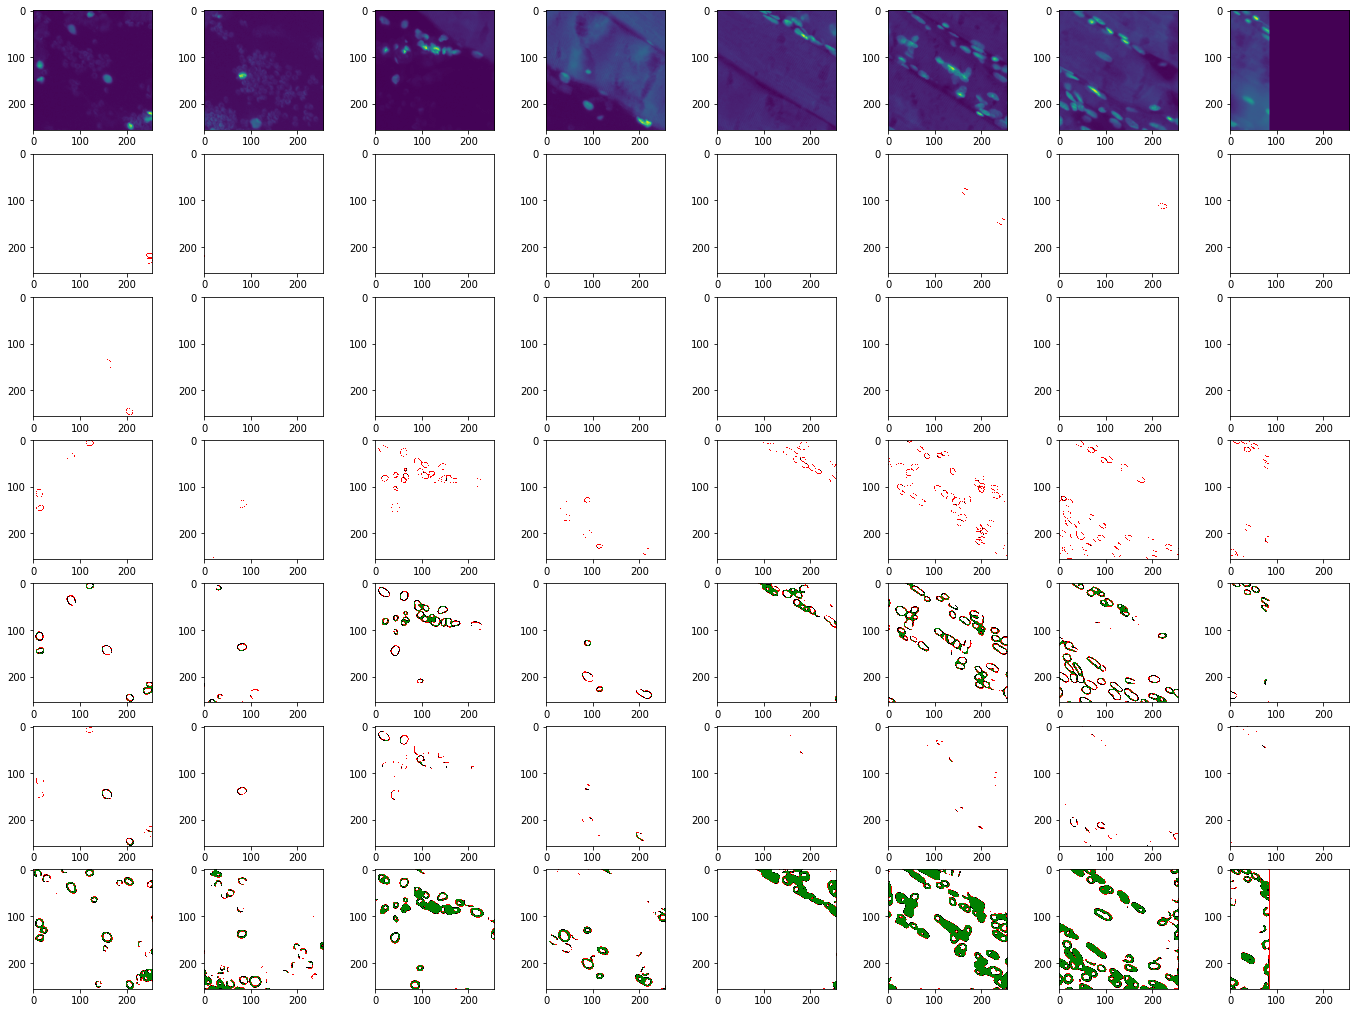

In [ ]:
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(['white', 'red', 'black','green'])

thres = 0.5

inputs, label, bdry, mask_label,target  = next(iter(dataloader['validation']))
output = model.cpu()(inputs)
output = (output > thres).float()

plt.figure(figsize=(24,18))
for _ in range(8):
    plt.subplot(7,8,_+1)
    plt.imshow(inputs[_].squeeze()[0,:,:].numpy())
    plt.subplot(7,8,_+9)
    plt.imshow(target[_].squeeze()[0,:,:].numpy(), cmap=cmap)
    plt.subplot(7,8,_+17)
    plt.imshow(target[_].squeeze()[1,:,:].numpy(), cmap=cmap)
    plt.subplot(7,8,_+25)
    plt.imshow(target[_].squeeze()[2,:,:].numpy(), cmap=cmap)
    plt.subplot(7,8,_+33)
    plt.imshow(output[_].squeeze()[0,:,:].numpy(), cmap=cmap)
    plt.subplot(7,8,_+41)
    plt.imshow(output[_].squeeze()[1,:,:].numpy(), cmap=cmap)
    plt.subplot(7,8,_+49)
    plt.imshow(output[_].squeeze()[2,:,:].numpy(), cmap=cmap)


In [ ]:
model = UNet(in_channels=4, out_channels=4, init_features=128) # https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
model_load = torch.load('/scratch/liy31/myjupyter/capstone/model_class/unet_f1_{:.3f}.pt'.format(0.110), map_location=device)
model = model_load['model'].to(device)

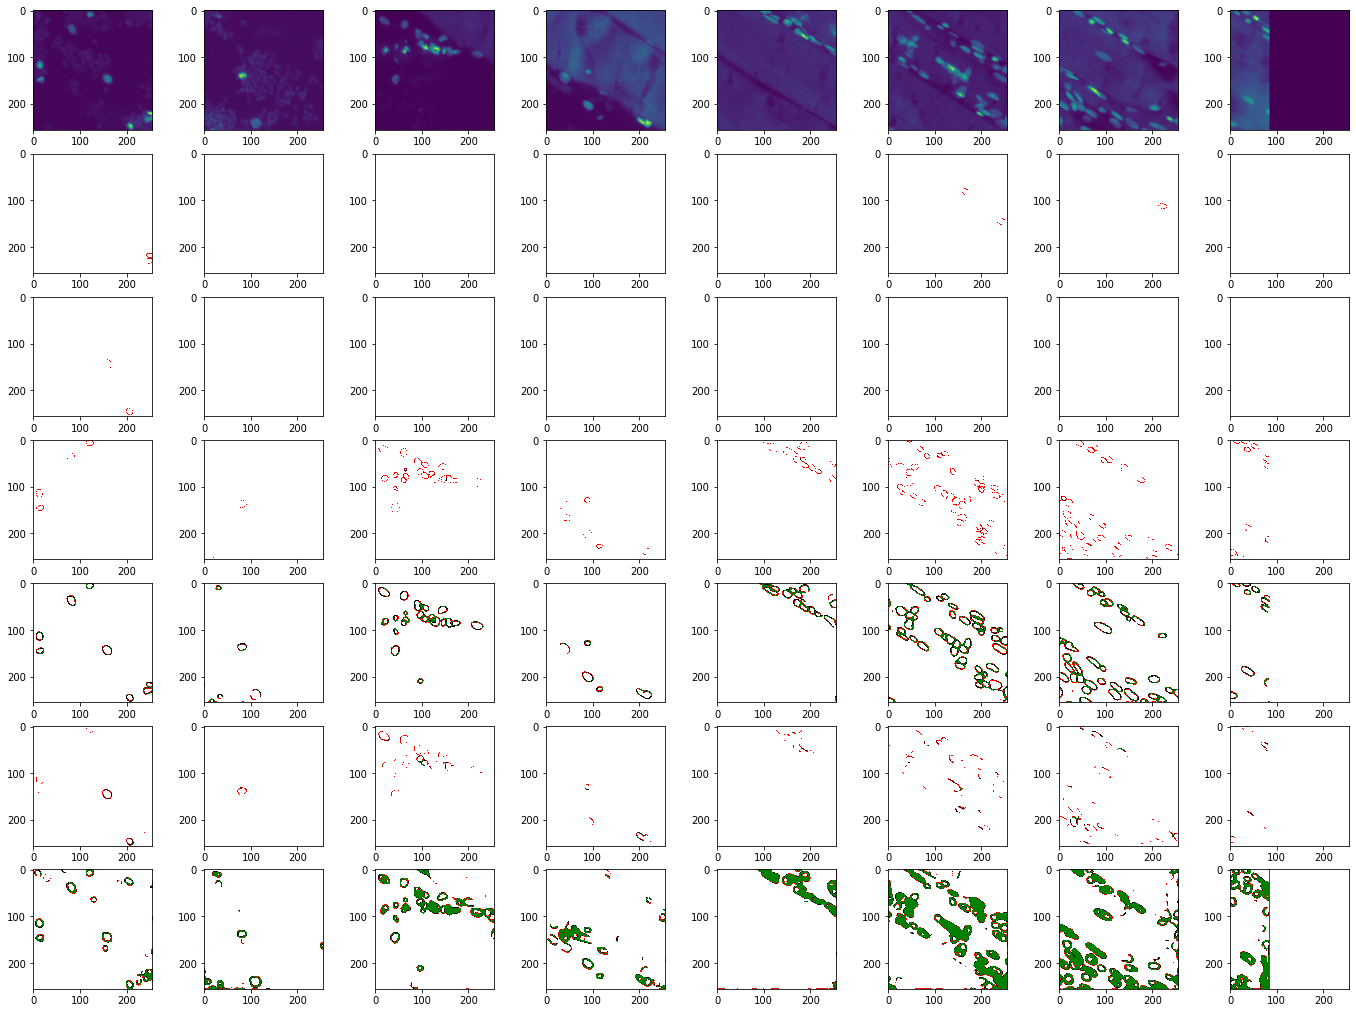

In [ ]:
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(['white', 'red', 'black','green'])

thres = 0.5

inputs, label, bdry, mask_label,target  = next(iter(dataloader['validation']))
output = model.cpu()(inputs)
output = (output > thres).float()

plt.figure(figsize=(24,18))
for _ in range(8):
    plt.subplot(7,8,_+1)
    plt.imshow(inputs[_].squeeze()[0,:,:].numpy())
    plt.subplot(7,8,_+9)
    plt.imshow(target[_].squeeze()[0,:,:].numpy(), cmap=cmap)
    plt.subplot(7,8,_+17)
    plt.imshow(target[_].squeeze()[1,:,:].numpy(), cmap=cmap)
    plt.subplot(7,8,_+25)
    plt.imshow(target[_].squeeze()[2,:,:].numpy(), cmap=cmap)
    plt.subplot(7,8,_+33)
    plt.imshow(output[_].squeeze()[0,:,:].numpy(), cmap=cmap)
    plt.subplot(7,8,_+41)
    plt.imshow(output[_].squeeze()[1,:,:].numpy(), cmap=cmap)
    plt.subplot(7,8,_+49)
    plt.imshow(output[_].squeeze()[2,:,:].numpy(), cmap=cmap)


In [ ]:
target[0].size()

torch.Size([1, 3, 256, 256])

In [ ]:
target[0]

tensor(251.)

In [ ]:
for _ in range(8,16):
    plt.subplot(6,8,_+17)
    plt.imshow(inputs[_].squeeze()[0,:,:].numpy())
    plt.subplot(6,8,_+25)
    plt.imshow(target[_].squeeze().numpy(), cmap=cmap)
    plt.subplot(6,8,_+33)
    plt.imshow(output[_].squeeze().numpy(), cmap=cmap)
plt.show()